# **DATA PREPARATION**

In [1]:
!pip install Sastrawi
!pip install transformers
!pip install tensorflow
!pip install scikit-learn
!pip install seaborn matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
from tqdm.notebook import tqdm

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from transformers import BertTokenizer, TFBertForSequenceClassification

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None 
tqdm.pandas()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## Load Data dan Eksplorasi

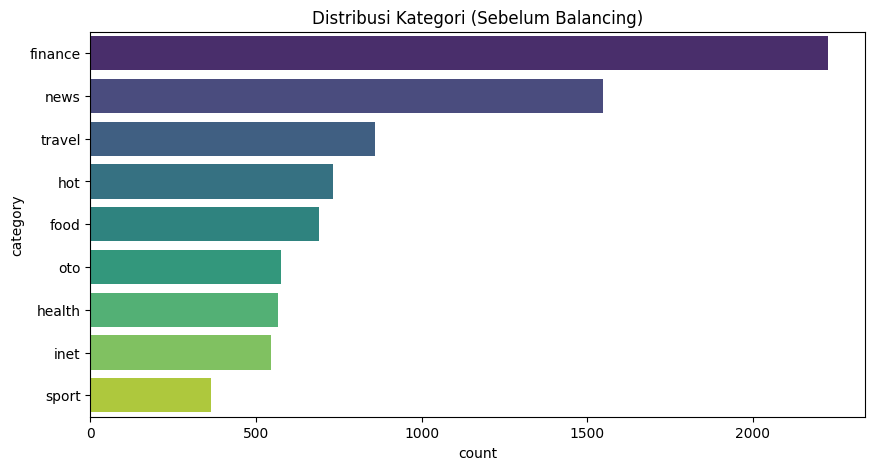


Total Data Awal: 8111


In [3]:
files = [
    '/kaggle/input/scrapingdetik/scraping_news_finance_hot.json',
    '/kaggle/input/scrapingdetik/scraping_inet_sport_oto.json',
    '/kaggle/input/scrapingdetik/scraping_travel_food_health.json'
]

dfs = []
for f in files:
    try:
        with open(f, 'r') as file:
            data = json.load(file)
            dfs.append(pd.DataFrame(data))
    except FileNotFoundError:
        print(f"File {f} tidak ditemukan.")

df = pd.concat(dfs, ignore_index=True)

df.drop_duplicates(subset=['content', 'category'], inplace=True)
df = df[df['content'].str.strip() != '']

print(f"\nTotal Data Awal: {df.shape[0]}\n")

plt.figure(figsize=(10, 5))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')
plt.title('Distribusi Kategori (Sebelum Balancing)')
plt.show()

## Data Cleaning

In [4]:
factory_stop = StopWordRemoverFactory()
stopword_remover = factory_stop.create_stop_word_remover()

factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

def clean_text(text):
    text = str(text).lower()                             # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)    # Hapus URL
    text = re.sub(r'\d+', '', text)                      # Hapus Angka
    text = re.sub(r'[^\w\s]', '', text)                  # Hapus Tanda Baca
    text = re.sub(r'\s+', ' ', text).strip()             # Hapus Spasi Berlebih
    text = stopword_remover.remove(text)                 # Stopwords Removal
    text = stemmer.stem(text) 
    return text

print("[INFO] Memulai proses cleaning")
df['clean_content'] = df['content'].progress_apply(clean_text)

df['word_count'] = df['clean_content'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] > 20]

df[['content', 'clean_content']].head()

[INFO] Memulai proses cleaning


  0%|          | 0/8111 [00:00<?, ?it/s]

,content,clean_content
0,Polres Metro Tangerang Kota berbagi sembako de...,polres metro tangerang kota bagi sembako masya...
2,Presiden Korea Selatan sekaligus Ketua APEC 20...,presiden korea selatan sekaligus ketua apec le...
3,Venezuela khawatir peningkatan kekuatan milite...,venezuela khawatir tingkat kuat militer amerik...
5,Sekelompok orang bersenjata melakukan penembak...,kelompok orang senjata laku tembak jumlah ruma...
7,Komandan Resort Militer (Danrem) 031/Wira Bima...,komandan resort militer danrem wira bima brigj...


## Balancing Dataset

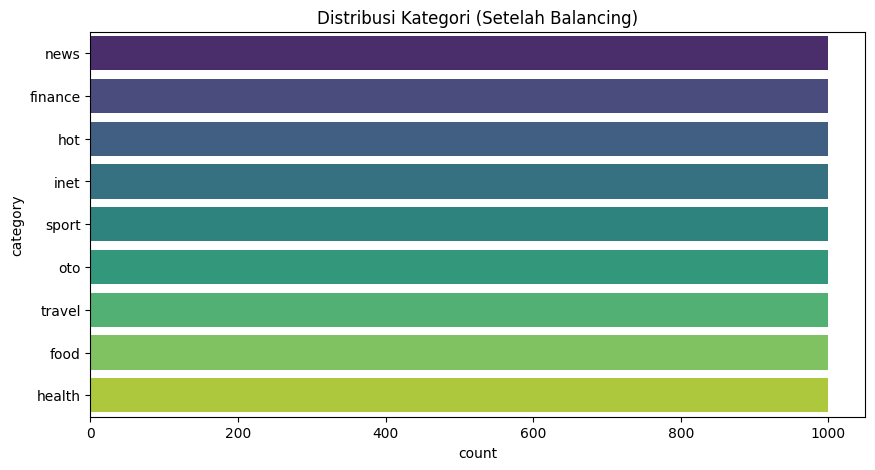


Total Data Final: 9000 baris


In [5]:
TARGET_COUNT = 1000

def balance_data(dataframe, target_col='category', n_samples=1000):
    df_balanced = pd.DataFrame()
    
    for category in dataframe[target_col].unique():
        df_class = dataframe[dataframe[target_col] == category]
        
        if len(df_class) < n_samples:
            df_resampled = resample(df_class, 
                                    replace=True,
                                    n_samples=n_samples, 
                                    random_state=42)
        else:
            df_resampled = resample(df_class, 
                                    replace=False,
                                    n_samples=n_samples, 
                                    random_state=42)
        
        df_balanced = pd.concat([df_balanced, df_resampled])
    
    return df_balanced

df_final = balance_data(df, target_col='category', n_samples=TARGET_COUNT)

print(f"\nTotal Data Final: {df_final.shape[0]} baris\n")

plt.figure(figsize=(10, 5))
sns.countplot(y='category', data=df_final, order=df_final['category'].value_counts().index, palette='viridis')
plt.title(f'Distribusi Kategori (Setelah Balancing)')
plt.show()

## Label Encoding

In [6]:
le = LabelEncoder()
df_final['label'] = le.fit_transform(df_final['category'])
num_classes = len(le.classes_)
print("Classes:", le.classes_)

label_map = dict(zip(le.classes_, le.transform(le.classes_)))

Classes: ['finance' 'food' 'health' 'hot' 'inet' 'news' 'oto' 'sport' 'travel']


## Tokenisasi LSTM-GRU

In [8]:
MAX_VOCAB = 15000
MAX_LEN = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df_final['clean_content'])
sequences = tokenizer.texts_to_sequences(df_final['clean_content'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

Y_labels =  tf.keras.utils.to_categorical(df_final['label'], num_classes)

word_index = tokenizer.word_index
print(f"Mendapat {len(word_index)} unique token.")

Mendapat 40937 unique token.


## Tokenisasi BERT

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

print("[INFO] Encoding data untuk BERT")
input_ids, attention_masks = bert_encode(df_final['clean_content'].values, MAX_LEN)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

[INFO] Encoding data untuk BERT


In [10]:
import pickle

df_final.to_json('final_data_detik.json', orient='records')

with open('tokenizer_keras.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Semua file aset berhasil disimpan.")

Semua file aset berhasil disimpan.


# **BERT MODEL EXPERIMENTS**

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import logging
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

logging.getLogger("transformers").setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

2025-12-08 15:52:49.192722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765209169.423304      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765209169.482194      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
try:
    df = pd.read_json('/kaggle/input/finalscrapingdetik/final_data_detik.json')
except:
    print("File json tidak ditemukan, pastikan preprocessing sudah dijalankan dan disave.")

with open('/kaggle/input/finalscrapingdetik/label_encoder.pickle', 'rb') as handle:
    le = pickle.load(handle)
num_classes = len(le.classes_)

bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
MAX_LEN = 100

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

input_ids, attention_masks = bert_encode(df['clean_content'].values, MAX_LEN)
y_indices = df['label'].values

print(f"Jumlah sampel: {len(input_ids)}")

Jumlah sampel: 9000


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

X_train_id, X_test_id, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, 
    attention_masks, 
    y_indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_indices
)

print(f"Data Training : {len(X_train_id)} sampel")
print(f"Data Testing  : {len(X_test_id)} sampel")

Data Training : 7200 sampel
Data Testing  : 1800 sampel


In [28]:
def build_bert_model(learning_rate):
    model = TFBertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1', 
        num_labels=num_classes, 
        from_pt=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [33]:
print("\n=== TRAINING MODEL BASELINE ===")

baseline_lr = 2e-5
baseline_batch = 16
baseline_epoch = 3 

tf.keras.backend.clear_session()

model_baseline = build_bert_model(learning_rate=baseline_lr)

history_baseline = model_baseline.fit(
    [X_train_id, X_train_mask], 
    y_train,
    validation_data=([X_test_id, X_test_mask], y_test),
    epochs=baseline_epoch,
    batch_size=baseline_batch,
    verbose=1
)


=== TRAINING MODEL BASELINE ===
Epoch 1/3
450/450 [==============================] - 201s 381ms/step - loss: 0.5352 - accuracy: 0.8446 - val_loss: 0.3132 - val_accuracy: 0.9111
Epoch 2/3
450/450 [==============================] - 168s 372ms/step - loss: 0.1909 - accuracy: 0.9415 - val_loss: 0.2292 - val_accuracy: 0.9233
Epoch 3/3
450/450 [==============================] - 167s 371ms/step - loss: 0.1001 - accuracy: 0.9694 - val_loss: 0.2878 - val_accuracy: 0.9183


In [34]:
print("\n=== HASIL EVALUASI BASELINE ===")

preds_base = model_baseline.predict([X_test_id, X_test_mask], verbose=0)
y_pred_base = np.argmax(preds_base.logits, axis=1)

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='macro')

print(classification_report(y_test, y_pred_base, target_names=le.classes_))

print(f"Akurasi Baseline: {acc_base:.4f}")
print(f"Macro F1 Baseline: {f1_base:.4f}")


=== HASIL EVALUASI BASELINE ===
              precision    recall  f1-score   support

     finance       0.91      0.83      0.87       200
        food       0.99      0.94      0.97       200
      health       0.91      0.97      0.94       200
         hot       0.98      0.94      0.96       200
        inet       0.96      0.96      0.96       200
        news       0.74      0.85      0.79       200
         oto       0.96      0.91      0.93       200
       sport       0.92      0.99      0.95       200
      travel       0.92      0.86      0.89       200

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800

Akurasi Baseline: 0.9183
Macro F1 Baseline: 0.9191


In [9]:
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [16, 32] 
epochs_options = [3, 5]

k = 3
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

best_grid_acc = 0
best_grid_params = {}
results_history = [] 

print("\n=== MEMULAI GRID SEARCH BERT ===")

for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs_options:
            print(f"\nTraining Parameter: LR={lr}, Batch={bs}, Epochs={ep}")
            
            fold_accuracies = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(input_ids, y_indices)):
                tf.keras.backend.clear_session()
                
                X_train_id, X_val_id = input_ids[train_idx], input_ids[val_idx]
                X_train_mask, X_val_mask = attention_masks[train_idx], attention_masks[val_idx]
                y_train, y_val = y_indices[train_idx], y_indices[val_idx]
                
                model = build_bert_model(lr)
                
                try:
                    model.fit(
                        [X_train_id, X_train_mask], y_train,
                        epochs=ep,
                        batch_size=bs,
                        verbose=1
                    )
                    
                    preds = model.predict([X_val_id, X_val_mask], verbose=0)
                    acc = accuracy_score(y_val, np.argmax(preds.logits, axis=1))
                    fold_accuracies.append(acc)
                    
                except tf.errors.ResourceExhaustedError:
                    print(f"  [OOM] Skip batch {bs}, memori tidak cukup.")
                    fold_accuracies.append(0)
                    break
            
            if len(fold_accuracies) > 0:
                avg_acc = np.mean(fold_accuracies)
                print(f"--> Rata-rata Akurasi: {avg_acc:.4f}")
                
                results_history.append({'params': (lr, bs, ep), 'acc': avg_acc})
                
                if avg_acc > best_grid_acc:
                    best_grid_acc = avg_acc
                    best_grid_params = {'learning_rate': lr, 'batch_size': bs, 'epochs': ep}
                    print("    (NEW BEST SCORE!)")

print("\n=== HASIL AKHIR GRID SEARCH ===")
print(f"Parameter Terbaik: {best_grid_params}")
print(f"Akurasi Tertinggi: {best_grid_acc:.4f}")


=== MEMULAI GRID SEARCH BERT ===

Training Parameter: LR=2e-05, Batch=16, Epochs=3
Epoch 1/3
375/375 [==============================] - 153s 329ms/step - loss: 0.5893 - accuracy: 0.8250
Epoch 2/3
375/375 [==============================] - 128s 342ms/step - loss: 0.2064 - accuracy: 0.9358
Epoch 3/3
375/375 [==============================] - 129s 343ms/step - loss: 0.1042 - accuracy: 0.9720
Epoch 1/3
375/375 [==============================] - 158s 346ms/step - loss: 0.6095 - accuracy: 0.8200
Epoch 2/3
375/375 [==============================] - 128s 342ms/step - loss: 0.2147 - accuracy: 0.9355
Epoch 3/3
375/375 [==============================] - 129s 344ms/step - loss: 0.1116 - accuracy: 0.9672
Epoch 1/3
375/375 [==============================] - 160s 347ms/step - loss: 0.5895 - accuracy: 0.8215
Epoch 2/3
375/375 [==============================] - 129s 343ms/step - loss: 0.2072 - accuracy: 0.9385
Epoch 3/3
375/375 [==============================] - 129s 344ms/step - loss: 0.1100 - accura

In [11]:
import optuna

print("\n=== MEMULAI BAYESIAN OPTIMIZATION ===")

def objective(trial):
    tf.keras.backend.clear_session()
    
    lr = trial.suggest_categorical('learning_rate', [2e-5, 3e-5, 5e-5])
    bs = trial.suggest_categorical('batch_size', [16, 32])
    ep = trial.suggest_int('epochs', 3, 5) 
    
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(input_ids, y_indices)):
        
        X_train_id, X_val_id = input_ids[train_idx], input_ids[val_idx]
        X_train_mask, X_val_mask = attention_masks[train_idx], attention_masks[val_idx]
        y_train, y_val = y_indices[train_idx], y_indices[val_idx]
        
        try:
            model = build_bert_model(lr)
            
            model.fit(
                [X_train_id, X_train_mask], y_train,
                epochs=ep,
                batch_size=bs,
                verbose=1
            )
            
            preds = model.predict([X_val_id, X_val_mask], verbose=0)
            acc = accuracy_score(y_val, np.argmax(preds.logits, axis=1))
            fold_accuracies.append(acc)
            
        except tf.errors.ResourceExhaustedError:
            return 0.0
            
    return np.mean(fold_accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

best_bayes_acc = study.best_value
best_bayes_params = study.best_params

print("\n=== HASIL AKHIR BAYESIAN ===")
print(f"Best Bayesian Params: {best_bayes_params}")
print(f"Best Bayesian Acc: {best_bayes_acc:.4f}")

[I 2025-12-08 21:50:04,288] A new study created in memory with name: no-name-8bb4602b-375e-4504-aa4e-d322e753d129



=== MEMULAI BAYESIAN OPTIMIZATION ===
Epoch 1/3
375/375 [==============================] - 161s 347ms/step - loss: 0.5937 - accuracy: 0.8253
Epoch 2/3
375/375 [==============================] - 129s 344ms/step - loss: 0.2127 - accuracy: 0.9365
Epoch 3/3
375/375 [==============================] - 129s 345ms/step - loss: 0.1012 - accuracy: 0.9702
Epoch 1/3
375/375 [==============================] - 161s 347ms/step - loss: 0.5971 - accuracy: 0.8163
Epoch 2/3
375/375 [==============================] - 129s 343ms/step - loss: 0.2025 - accuracy: 0.9397
Epoch 3/3
375/375 [==============================] - 129s 344ms/step - loss: 0.1094 - accuracy: 0.9687
Epoch 1/3
375/375 [==============================] - 158s 346ms/step - loss: 0.6122 - accuracy: 0.8187
Epoch 2/3
375/375 [==============================] - 128s 343ms/step - loss: 0.1957 - accuracy: 0.9445
Epoch 3/3
375/375 [==============================] - 128s 342ms/step - loss: 0.0935 - accuracy: 0.9738


[I 2025-12-08 22:12:15,012] Trial 0 finished with value: 0.9278888888888889 and parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}. Best is trial 0 with value: 0.9278888888888889.


Epoch 1/5
188/188 [==============================] - 161s 678ms/step - loss: 0.5972 - accuracy: 0.8188
Epoch 2/5
188/188 [==============================] - 126s 671ms/step - loss: 0.2192 - accuracy: 0.9367
Epoch 3/5
188/188 [==============================] - 126s 671ms/step - loss: 0.1122 - accuracy: 0.9642
Epoch 4/5
188/188 [==============================] - 127s 674ms/step - loss: 0.0787 - accuracy: 0.9790
Epoch 5/5
188/188 [==============================] - 127s 673ms/step - loss: 0.0556 - accuracy: 0.9843
Epoch 1/5
188/188 [==============================] - 163s 679ms/step - loss: 0.5854 - accuracy: 0.8177
Epoch 2/5
188/188 [==============================] - 126s 672ms/step - loss: 0.1859 - accuracy: 0.9430
Epoch 3/5
188/188 [==============================] - 126s 671ms/step - loss: 0.1303 - accuracy: 0.9593
Epoch 4/5
188/188 [==============================] - 127s 674ms/step - loss: 0.0760 - accuracy: 0.9782
Epoch 5/5
188/188 [==============================] - 127s 675ms/step - lo

[I 2025-12-08 22:46:58,743] Trial 1 finished with value: 0.9317777777777779 and parameters: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 5}. Best is trial 1 with value: 0.9317777777777779.


Epoch 1/5
375/375 [==============================] - 161s 347ms/step - loss: 0.5811 - accuracy: 0.8160
Epoch 2/5
375/375 [==============================] - 129s 344ms/step - loss: 0.2056 - accuracy: 0.9393
Epoch 3/5
375/375 [==============================] - 129s 343ms/step - loss: 0.1352 - accuracy: 0.9602
Epoch 4/5
375/375 [==============================] - 129s 345ms/step - loss: 0.1082 - accuracy: 0.9677
Epoch 5/5
375/375 [==============================] - 129s 344ms/step - loss: 0.0653 - accuracy: 0.9823
Epoch 1/5
375/375 [==============================] - 163s 348ms/step - loss: 0.5894 - accuracy: 0.8205
Epoch 2/5
375/375 [==============================] - 129s 344ms/step - loss: 0.2268 - accuracy: 0.9322
Epoch 3/5
375/375 [==============================] - 129s 344ms/step - loss: 0.1389 - accuracy: 0.9612
Epoch 4/5
375/375 [==============================] - 129s 343ms/step - loss: 0.0903 - accuracy: 0.9750
Epoch 5/5
375/375 [==============================] - 129s 344ms/step - lo

[I 2025-12-08 23:22:07,338] Trial 2 finished with value: 0.9291111111111111 and parameters: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 1 with value: 0.9317777777777779.


Epoch 1/4
375/375 [==============================] - 161s 347ms/step - loss: 0.5809 - accuracy: 0.8287
Epoch 2/4
375/375 [==============================] - 129s 344ms/step - loss: 0.1935 - accuracy: 0.9438
Epoch 3/4
375/375 [==============================] - 129s 344ms/step - loss: 0.0951 - accuracy: 0.9713
Epoch 4/4
375/375 [==============================] - 129s 344ms/step - loss: 0.0487 - accuracy: 0.9872
Epoch 1/4
375/375 [==============================] - 162s 347ms/step - loss: 0.6154 - accuracy: 0.8157
Epoch 2/4
375/375 [==============================] - 129s 344ms/step - loss: 0.2048 - accuracy: 0.9377
Epoch 3/4
375/375 [==============================] - 129s 344ms/step - loss: 0.1126 - accuracy: 0.9658
Epoch 4/4
375/375 [==============================] - 129s 344ms/step - loss: 0.0661 - accuracy: 0.9807
Epoch 1/4
375/375 [==============================] - 159s 348ms/step - loss: 0.5971 - accuracy: 0.8218
Epoch 2/4
375/375 [==============================] - 129s 344ms/step - lo

[I 2025-12-08 23:50:48,581] Trial 3 finished with value: 0.9402222222222223 and parameters: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4}. Best is trial 3 with value: 0.9402222222222223.


Epoch 1/5
375/375 [==============================] - 162s 348ms/step - loss: 0.5736 - accuracy: 0.8283
Epoch 2/5
375/375 [==============================] - 129s 345ms/step - loss: 0.1990 - accuracy: 0.9445
Epoch 3/5
375/375 [==============================] - 129s 344ms/step - loss: 0.1235 - accuracy: 0.9610
Epoch 4/5
375/375 [==============================] - 130s 346ms/step - loss: 0.0574 - accuracy: 0.9837
Epoch 5/5
375/375 [==============================] - 130s 345ms/step - loss: 0.0612 - accuracy: 0.9843
Epoch 1/5
375/375 [==============================] - 162s 348ms/step - loss: 0.5808 - accuracy: 0.8205
Epoch 2/5
375/375 [==============================] - 129s 344ms/step - loss: 0.2097 - accuracy: 0.9358
Epoch 3/5
375/375 [==============================] - 129s 345ms/step - loss: 0.1044 - accuracy: 0.9687
Epoch 4/5
375/375 [==============================] - 129s 345ms/step - loss: 0.0677 - accuracy: 0.9822
Epoch 5/5
375/375 [==============================] - 129s 344ms/step - lo

[I 2025-12-09 00:26:00,083] Trial 4 finished with value: 0.923111111111111 and parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 3 with value: 0.9402222222222223.



=== HASIL AKHIR BAYESIAN ===
Best Bayesian Params: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4}
Best Bayesian Acc: 0.9402


In [14]:
all_results = [
    {'method': 'Grid Search', 'acc': best_grid_acc, 'params': best_grid_params},
    {'method': 'Bayesian', 'acc': best_bayes_acc, 'params': best_bayes_params}
]

sorted_results = sorted(all_results, key=lambda x: x['acc'], reverse=True)
best_param = sorted_results[0]

print(f"\nFinal Method: {best_param['method']} dengan Akurasi {best_param['acc']:.4f}")
print(f"Parameter Terbaik: {best_param['params']}")


Final Method: Bayesian dengan Akurasi 0.9402
Parameter Terbaik: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4}


In [35]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import logging
from transformers import BertTokenizer, TFBertForSequenceClassification

logging.getLogger("transformers").setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

In [36]:
try:
    df = pd.read_json('/kaggle/input/finalscrapingdetik/final_data_detik.json')
except:
    print("Error: File 'final_data_detik.json' tidak ditemukan. Pastikan sudah di-upload/run preprocessing.")

with open('/kaggle/input/finalscrapingdetik/label_encoder.pickle', 'rb') as handle:
    le = pickle.load(handle)
num_classes = len(le.classes_)

print(f"Data Loaded. Jumlah Data: {len(df)}")

Data Loaded. Jumlah Data: 9000


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

X_train_id, X_test_id, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, 
    attention_masks, 
    y_indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_indices
)

print(f"Data Training : {len(X_train_id)} sampel")
print(f"Data Testing  : {len(X_test_id)} sampel")

Data Training : 7200 sampel
Data Testing  : 1800 sampel


In [38]:
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
MAX_LEN = 100

def bert_encode(data):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

input_ids, attention_masks = bert_encode(df['clean_content'].values)
y_indices = df['label'].values

print("Tokenisasi Selesai.")

Tokenisasi Selesai.


In [41]:
print("\n=== TRAINING MODEL FINAL===")

final_lr = 2e-5
final_batch = 16
final_epoch = 4

tf.keras.backend.clear_session()

model_final = build_bert_model(learning_rate=final_lr)

history_final = model_final.fit(
    [X_train_id, X_train_mask], 
    y_train,
    validation_data=([X_test_id, X_test_mask], y_test),
    epochs=final_epoch,
    batch_size=final_batch,
    verbose=1
)


=== TRAINING MODEL FINAL===
Epoch 1/4
450/450 [==============================] - 204s 382ms/step - loss: 0.5653 - accuracy: 0.8272 - val_loss: 0.2688 - val_accuracy: 0.9150
Epoch 2/4
450/450 [==============================] - 168s 373ms/step - loss: 0.1819 - accuracy: 0.9458 - val_loss: 0.2036 - val_accuracy: 0.9417
Epoch 3/4
450/450 [==============================] - 167s 372ms/step - loss: 0.0946 - accuracy: 0.9725 - val_loss: 0.1879 - val_accuracy: 0.9456
Epoch 4/4
450/450 [==============================] - 168s 373ms/step - loss: 0.0493 - accuracy: 0.9853 - val_loss: 0.2480 - val_accuracy: 0.9383


In [46]:
from sklearn.metrics import classification_report, f1_score

print("\n=== HASIL EVALUASI FINAL ===")

preds_final = model_final.predict([X_test_id, X_test_mask], verbose=0)
y_pred_final = np.argmax(preds_final.logits, axis=1)

acc_final = accuracy_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final, average='macro')

print(classification_report(y_test, y_pred_final, target_names=le.classes_))

print(f"Akurasi Final: {acc_final:.4f}")
print(f"Macro F1 Final: {f1_final:.4f}")


=== HASIL EVALUASI FINAL ===
              precision    recall  f1-score   support

     finance       0.94      0.80      0.86       200
        food       0.96      0.98      0.97       200
      health       0.94      0.98      0.96       200
         hot       0.98      0.93      0.96       200
        inet       0.97      0.99      0.98       200
        news       0.84      0.88      0.86       200
         oto       0.91      0.99      0.95       200
       sport       0.94      1.00      0.97       200
      travel       0.97      0.90      0.93       200

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800

Akurasi Final: 0.9383
Macro F1 Final: 0.9376


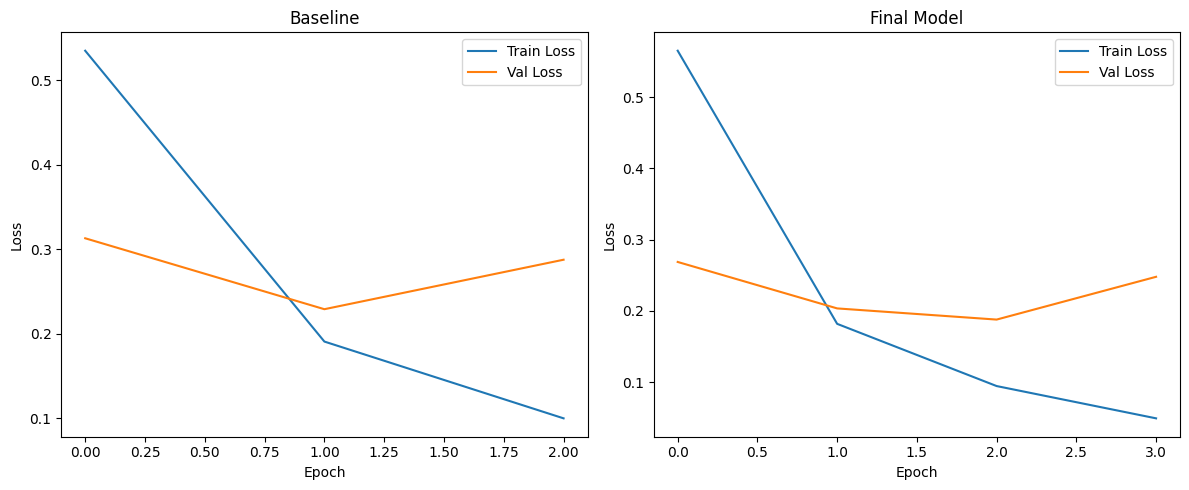

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Val Loss')
plt.title(f'Baseline')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title(f'Final Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

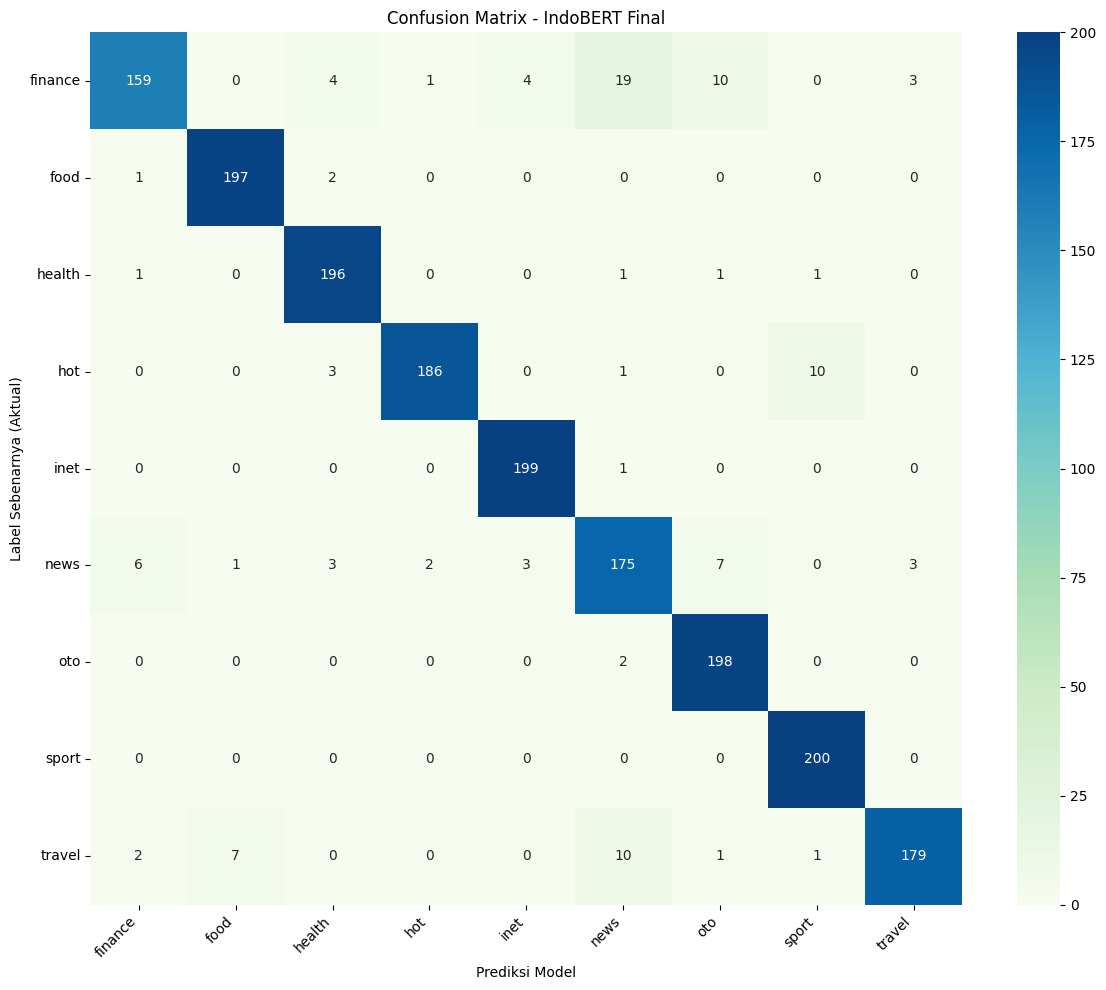

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_final) 

plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', 
                 xticklabels=le.classes_, yticklabels=le.classes_)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (Aktual)')

plt.title('Confusion Matrix - IndoBERT Final') 
plt.tight_layout()
plt.show()

In [50]:
save_path = "./indobert_detiknews_final"
final_model.save_pretrained(save_path)
bert_tokenizer.save_pretrained(save_path)

print(f"\nModel tersimpan di folder '{save_path}'")


Model tersimpan di folder './indobert_detiknews_final'
